In [2]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px

In [3]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

def visualize_trafic(df, center={"lat":37.6458, "lon":-122.4056}, zoom=9):
    fig = px.scatter_mapbox(df,
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phone",
                            
                            labels="phone",
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()

    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

def add_distance_diff(df):
    # shift(1): 上のやつが1個下に下がる → 前のデータ
    # shift(-1): 下のやつが1個上に上がる → 次のデータ
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['latDeg_gt_prev'] = df['latDeg_gt'].shift(1)
    df['latDeg_gt_next'] = df['latDeg_gt'].shift(-1)
    df['lngDeg_gt_prev'] = df['lngDeg_gt'].shift(1)
    df['lngDeg_gt_next'] = df['lngDeg_gt'].shift(-1)
    
    df['latDeg_prev_diff'] = df['latDeg'] - df['latDeg_prev']
    df['latDeg_next_diff'] = df['latDeg_next'] - df['latDeg']
    df['latDeg_gt_prev_diff'] = df['latDeg_gt'] - df['latDeg_gt_prev']
    df['latDeg_gt_next_diff'] = df['latDeg_gt_next'] - df['latDeg_gt']
    
    df['lngDeg_prev_diff'] = df['lngDeg'] - df['lngDeg_prev']
    df['lngDeg_next_diff'] = df['lngDeg_next'] - df['lngDeg']
    df['lngDeg_gt_prev_diff'] = df['lngDeg_gt'] - df['lngDeg_gt_prev']
    df['lngDeg_gt_next_diff'] = df['lngDeg_gt_next'] - df['lngDeg_gt']
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df['dist_gt_prev'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg_gt_prev'], df['lngDeg_gt_prev'])
    df['dist_gt_next'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg_gt_next'], df['lngDeg_gt_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev', 
                                           'latDeg_gt_prev', 'lngDeg_gt_prev', 'dist_gt_prev',
                                          'latDeg_prev_diff', 'latDeg_gt_prev_diff',
                                          'lngDeg_prev_diff', 'lngDeg_gt_prev_diff']] = np.nan
    
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next', 
                                           'latDeg_gt_next', 'lngDeg_gt_next', 'dist_gt_next',
                                          'latDeg_next_diff', 'latDeg_gt_next_diff',
                                          'lngDeg_next_diff', 'lngDeg_gt_next_diff']] = np.nan
    
    return df


def add_distance_nogt_diff(df):
    # shift(1): 上のやつが1個下に下がる → 前のデータ
    # shift(-1): 下のやつが1個上に上がる → 次のデータ
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['latDeg_prev_diff'] = df['latDeg'] - df['latDeg_prev']
    df['latDeg_next_diff'] = df['latDeg_next'] - df['latDeg']
    
    df['lngDeg_prev_diff'] = df['lngDeg'] - df['lngDeg_prev']
    df['lngDeg_next_diff'] = df['lngDeg_next'] - df['lngDeg']

    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev', 
                                          'latDeg_prev_diff', 'lngDeg_prev_diff']] = np.nan
    
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next', 
                                           'latDeg_next_diff', 'lngDeg_next_diff']] = np.nan
    
    return df

def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    # df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    df = df.merge(gt, on=['phone', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    # df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95]) # phoneによってgroupbyし、gtと予測値の差(err)の50%,95%値を求める
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

def get_all_train_score(df):
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    # df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95]) # phoneによってgroupbyし、gtと予測値の差(err)の50%,95%値を求める
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [4]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")
train_df = pd.read_csv(data_dir / "baseline_locations_train.csv")

# get all ground truth dataframe
gt_df = pd.DataFrame()
for (collection_name, phone_name), df in tqdm(train_df.groupby(["collectionName", "phoneName"])):
    path = data_dir / f"train/{collection_name}/{phone_name}/ground_truth.csv"
    df = pd.read_csv(path)  
    gt_df = pd.concat([gt_df, df]).reset_index(drop=True)   

  0%|          | 0/73 [00:00<?, ?it/s]

# Target Place

In [5]:
target_collection = '2021-04-29-US-SJC-2'
target_gt_df = gt_df[gt_df["collectionName"]==target_collection].reset_index(drop=True)
# for scoring
target_gt_df['phone'] = target_gt_df['collectionName'] + '_' + target_gt_df['phoneName']

train = train_df[train_df['collectionName']==target_collection]

In [6]:
from shapely.geometry import Point
import osmnx as ox
import momepy
import geopandas as gpd
import folium

/Users/shugo/Desktop/Competitions/kaggle/outdoor/venv_outdoor/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [7]:
# change pd.DataFrame -> gpd.GeoDataFrame
target_gt_df["geometry"] = [Point(p) for p in target_gt_df[["lngDeg", "latDeg"]].to_numpy()]
target_gt_gdf = gpd.GeoDataFrame(target_gt_df, geometry=target_gt_df["geometry"])

In [8]:
# get road data from open street map by osmnx
offset = 0.1**5
bbox = target_gt_gdf.bounds + [-offset, -offset, offset, offset]
east = bbox["minx"].min()
west = bbox["maxx"].max()
south = bbox["miny"].min()
north = bbox["maxy"].max()
G = ox.graph.graph_from_bbox(north, south, east, west, network_type='drive')

In [9]:
# ox.folium.plot_graph_folium(G)

In [10]:
nodes, edges = momepy.nx_to_gdf(G)

/Users/shugo/Desktop/Competitions/kaggle/outdoor/venv_outdoor/lib/python3.7/site-packages/momepy/utils.py:418: UserWarning: Approach is not set. Defaulting to 'primal'.
  warnings.warn("Approach is not set. Defaulting to 'primal'.")


In [11]:
nodes.head()

,y,x,highway,street_count,nodeID,ref,geometry
0,37.335294,-121.897948,stop,3,0,NaN,POINT (-121.89795 37.33529)
1,37.335370,-121.896596,stop,3,1,NaN,POINT (-121.89660 37.33537)
2,37.336402,-121.898691,traffic_signals,4,2,NaN,POINT (-121.89869 37.33640)
3,37.336552,-121.898785,traffic_signals,4,3,NaN,POINT (-121.89878 37.33655)
4,37.337067,-121.897707,NaN,3,4,NaN,POINT (-121.89771 37.33707)


In [12]:
edges.head()

,osmid,name,highway,oneway,length,geometry,lanes,bridge,maxspeed,ref,access,node_start,node_end
0,41932176,North Almaden Boulevard,secondary,False,120.474,"LINESTRING (-121.89795 37.33529, -121.89791 37...",NaN,NaN,NaN,NaN,NaN,0,1
1,41932176,North Almaden Boulevard,secondary,False,120.474,"LINESTRING (-121.89660 37.33537, -121.89673 37...",NaN,NaN,NaN,NaN,NaN,1,0
2,417910134,North Almaden Boulevard,secondary,True,62.399,"LINESTRING (-121.89660 37.33537, -121.89648 37...",NaN,NaN,NaN,NaN,NaN,1,111
3,417891836,West Julian Street,secondary,True,18.264,None,3,NaN,NaN,NaN,NaN,2,91
4,158245357,North Almaden Boulevard,secondary,True,139.706,"LINESTRING (-121.89869 37.33640, -121.89864 37...",1,NaN,NaN,NaN,NaN,2,0


<AxesSubplot:>

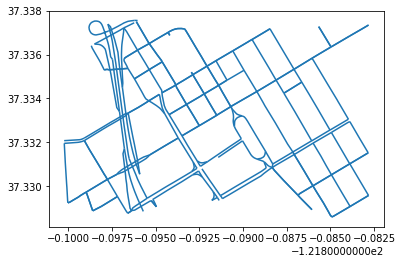

In [13]:
edges.plot()

<AxesSubplot:>

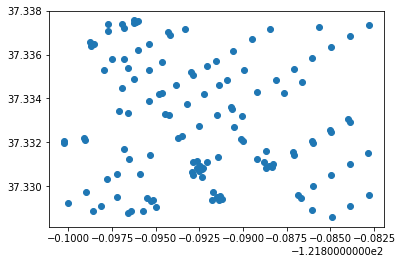

In [14]:
nodes.plot()

# only the relevent roads

In [15]:
edges = edges.dropna(subset=["geometry"]).reset_index(drop=True)
hits = bbox.apply(lambda row: list(edges.sindex.intersection(row)), axis=1)
tmp = pd.DataFrame({
    # index of points table
    "pt_idx": np.repeat(hits.index, hits.apply(len)),
    # ordinal position of line - access via iloc later
    "line_i": np.concatenate(hits.values)
})
# Join back to the lines on line_i; we use reset_index() to 
# give us the ordinal position of each line
tmp = tmp.join(edges.reset_index(drop=True), on="line_i")
# Join back to the original points to get their geometry
# rename the point geometry as "point"
tmp = tmp.join(target_gt_gdf.geometry.rename("point"), on="pt_idx")
# Convert back to a GeoDataFrame, so we can do spatial ops
tmp = gpd.GeoDataFrame(tmp, geometry="geometry", crs=target_gt_gdf.crs)

# Find closest road

In [16]:
tmp["snap_dist"] = tmp.geometry.distance(gpd.GeoSeries(tmp.point))

# Discard any lines that are greater than tolerance from points
tolerance = 0.0005  
tmp = tmp.loc[tmp.snap_dist <= tolerance]
# Sort on ascending snap distance, so that closest goes to top
tmp = tmp.sort_values(by=["snap_dist"])

# group by the index of the points and take the first, which is the
# closest line 
closest = tmp.groupby("pt_idx").first()
# construct a GeoDataFrame of the closest lines
closest = gpd.GeoDataFrame(closest, geometry="geometry")
closest = closest.drop_duplicates("line_i").reset_index(drop=True)

ipykernel_launcher:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

ipykernel_launcher:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None



<AxesSubplot:>

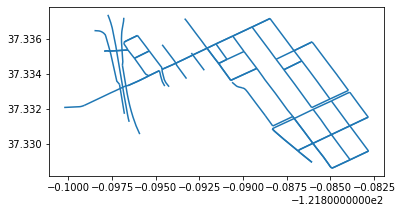

In [17]:
closest.plot()

In [18]:
closest.head()

,line_i,osmid,name,highway,oneway,length,geometry,lanes,bridge,maxspeed,ref,access,node_start,node_end,point,snap_dist
0,178.0,"[28357376, 395452213, 184867253, 946401467, 28...",None,motorway_link,True,388.907,"LINESTRING (-121.89851 37.33648, -121.89827 37...","[2, 1]",yes,None,None,None,91,49,POINT (-121.89810 37.33522),0.000482
1,1.0,41932176,North Almaden Boulevard,secondary,False,120.474,"LINESTRING (-121.89660 37.33537, -121.89673 37...","[2, 1]",yes,None,None,None,1,0,POINT (-121.89791 37.33529),0.000014
2,0.0,41932176,North Almaden Boulevard,secondary,False,120.474,"LINESTRING (-121.89795 37.33529, -121.89791 37...","[2, 1]",yes,None,None,None,0,1,POINT (-121.89783 37.33530),0.000014
3,58.0,"[28357317, 28357351, 28357352, 157782059, 2835...",Guadalupe Freeway,motorway,True,690.498,"LINESTRING (-121.89652 37.33125, -121.89657 37...",3,yes,65 mph,CA 87,None,28,51,POINT (-121.89723 37.33531),0.000013
4,2.0,417910134,North Almaden Boulevard,secondary,True,62.399,"LINESTRING (-121.89660 37.33537, -121.89648 37...",None,None,None,None,None,1,111,POINT (-121.89656 37.33528),0.000031


In [19]:
closest.shape

(107, 16)

# Generate road points

In [20]:
line_points_list = []
split = 50  # param: number of split in each LineString
for dist in range(0, split, 1):
    dist = dist/split
    line_points = closest["geometry"].interpolate(dist, normalized=True)
    line_points_list.append(line_points)
line_points = pd.concat(line_points_list).reset_index(drop=True)
line_points = line_points.reset_index().rename(columns={0:"geometry"})
line_points["lngDeg"] = line_points["geometry"].x
line_points["latDeg"] = line_points["geometry"].y

In [21]:
fig = px.scatter_mapbox(line_points,

                    # Here, plotly gets, (x,y) coordinates
                    lat="latDeg",
                    lon="lngDeg",

                    zoom=15,
                    center={"lat":37.33351, "lon":-121.8906},
                    height=600,
                    width=800)
fig.update_layout(mapbox_style='stamen-terrain')
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.update_layout(title_text="GPS trafic")
fig.show()

In [22]:
train = train_df.copy()
train = train[train['collectionName']==target_collection]

In [23]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist
    
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    # df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    df = df.merge(gt, on=['phone', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    # df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95]) # phoneによってgroupbyし、gtと予測値の差(err)の50%,95%値を求める
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [65]:
def find_closest_point(point, points, thr=3):
    """ Find closest point from a list of points. """
    df_ = pd.DataFrame({'latDeg':point['latDeg'].repeat(len(points)), 
                        'lngDeg':point['lngDeg'].repeat(len(points))},
                        columns=['latDeg', 'lngDeg'])
    # return minimum distance points
    distance = calc_haversine(points['latDeg'], points['lngDeg'],
                                 df_['latDeg'], df_['lngDeg']).min()
    if distance <= thr:
        return points.loc[calc_haversine(points['latDeg'], points['lngDeg'],
                            df_['latDeg'], df_['lngDeg']).argmin()]


def apply_grid_point(x, closest_point):
    '''
    input: 
        x: train row
        closest_point: closest point or None
    '''
    idx = x.name
    closest_point1 = closest_point[closest_point.index==idx]
    if closest_point1.isnull().values == True:
        pass
    else:
        x['latDeg'] = closest_point1.values[0]['latDeg']
        x['lngDeg'] = closest_point1.values[0]['lngDeg']
    return x

In [74]:
train1 = train.copy()
# parallel applyをすると出力が変わり、エラーが出る
closest_point = train1[['latDeg','lngDeg']].apply(lambda x: find_closest_point(x, line_points[['latDeg', 'lngDeg']], thr=50), axis=1)
train1[['latDeg', 'lngDeg']] = train1[['latDeg', 'lngDeg']].parallel_apply(apply_grid_point, closest_point=closest_point, axis=1)

In [75]:
print(get_train_score(train_df, target_gt_df))
print(get_train_score(train1, target_gt_df))

19.81370527195164
18.202081162835775
